In [1]:
from sklearn.datasets import fetch_lfw_people

In [18]:
import pandas as pd
import numpy as np

In [2]:
people = fetch_lfw_people(min_faces_per_person=150,resize=0.4)
X = people.data
Y = people.target

In [60]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [61]:
test_index = np.random.choice(len(X),len(X)//4,False)

In [62]:
train_index = list(set(range(len(X))).difference(set(test_index)))

In [98]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_PCA = pca.fit_transform(X)

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
def get_accuracy(model,x_train,y_train,x_test,y_test):
    score2 = sum(model.predict(x_train)==y_train)/len(y_train)
    score3 = sum(model.predict(x_test)==y_test)/len(y_test)
    
    return pd.DataFrame({'train_score':[score2],'test_score':[score3]})

In [100]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 2), random_state=1,max_iter=1000)
clf.fit(X_PCA[train_index],Y[train_index])

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 2), max_iter=1000,
              random_state=1, solver='lbfgs')

In [101]:
display(get_accuracy(clf,X_PCA[train_index],Y[train_index],X_PCA[test_index],Y[test_index]))
confusion_matrix(Y[test_index],clf.predict(X_PCA[test_index]))

,train_score,test_score
0,0.977391,0.958115


array([[ 57,   6],
       [  2, 126]], dtype=int64)

# -----------------------------------------------------------

In [118]:
df = [0]*3
df[0] = pd.read_csv('D:\\first_clustering_dataset.csv',names=['x','y'])
df[1] = pd.read_csv('D:\\second_clustering_dataset.csv',names=['x','y'])
df[2] = pd.read_csv('D:\\third_clustering_dataset.csv',names=['x','y'])

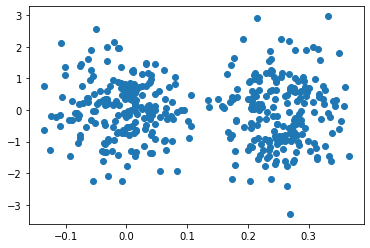

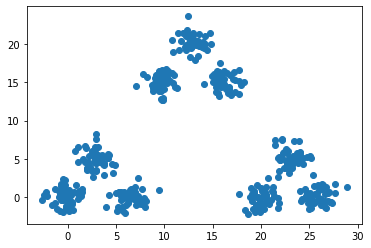

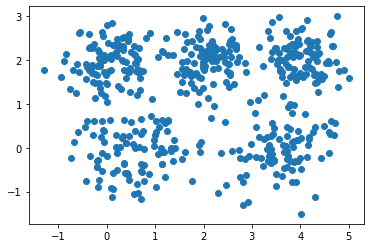

In [119]:
import matplotlib.pyplot as plt
for df_it in df:
    plt.scatter(df_it.x,df_it.y)
    plt.show()

as we see, the best clustring group number for this datas are 2,3 or 9, and 5

## K-means

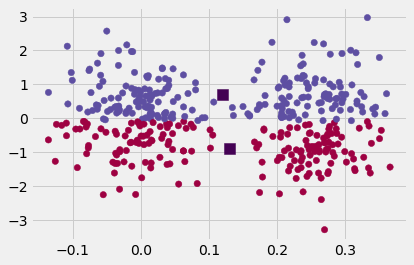

SSE: 146.8885600533513
silhouette_score: 0.5362906097948957


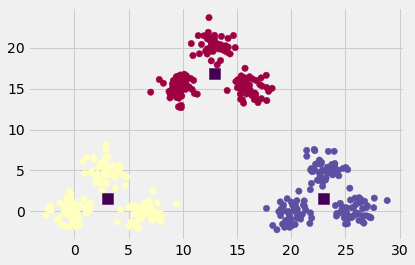

SSE: 6487.004526263209
silhouette_score: 0.7240379233766401


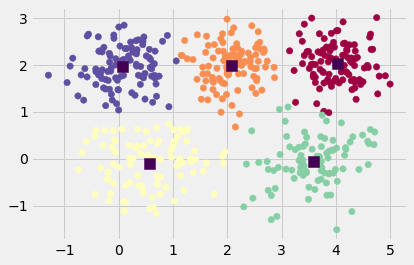

SSE: 222.36598776929108
silhouette_score: 0.5604142087131664


In [240]:
from sklearn.cluster import KMeans
for n,df_it in zip([2,3,5],df):
    model = KMeans(n_clusters= n, n_init=200)
    label = model.fit_predict(df_it)
    centroids = pd.DataFrame(model.cluster_centers_,columns=['x','y'])
    plt.scatter(df_it.x, df_it.y, s=40, c=label, cmap=plt.cm.Spectral)
    plt.scatter(centroids.x,centroids.y, s=120, c=[0]*n, marker='s')
    plt.show()
    print('SSE:',model.inertia_)
    print('silhouette_score:',silhouette_score(df_it, label))

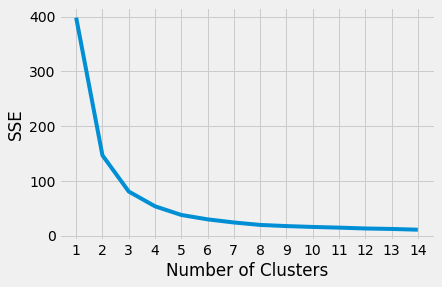

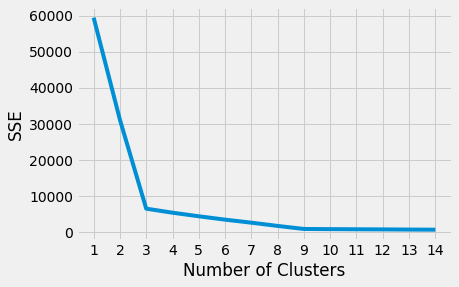

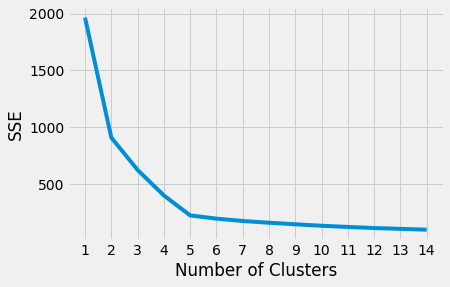

In [153]:
for df_it in df:
    sse = []
    for k in range(1, 15):
        model = KMeans(n_clusters=k, n_init=200)
        model.fit_predict(df_it)
        sse.append(model.inertia_)
    plt.plot(range(1, 15), sse)
    plt.xticks(range(1, 15))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

## Fuzzy C-means

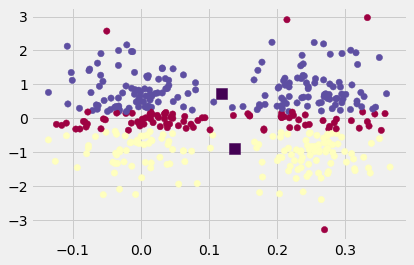

SSE: 146.97353305008744
silhouette_score: 0.5362906097948957


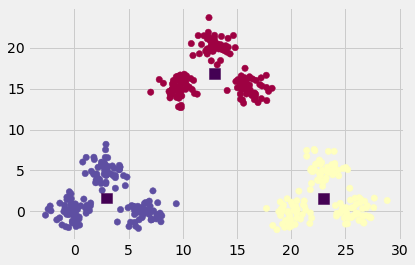

SSE: 6489.403251888046
silhouette_score: 0.7240379233766401


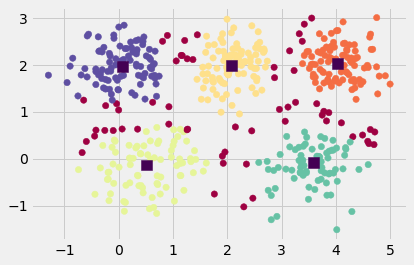

SSE: 222.85309578970023
silhouette_score: 0.5605130818892635


In [241]:
from fcmeans import FCM
def SSE_calc(df,label,centroids):
    s = 0
    for x,y,l in zip(df.x,df.y,label):
        s+=(x-centroids.loc[l,'x'])**2+(y-centroids.loc[l,'y'])**2
    return s
def is_fuzzy(row):
    return sum(pd.Series(row)>0.2)>1 
for n,df_it in zip([2,3,5],df):
    model = FCM(n_clusters= n)
    model.fit(df_it.to_numpy())
    label = model.predict(df_it.to_numpy())
    f_label = model.soft_predict(df_it.to_numpy())
    label_fuz = [-1 if is_fuzzy(f_label[id]) else e for id,e in enumerate(label)]
    centroids = pd.DataFrame(model.centers,columns=['x','y'])
    plt.scatter(df_it.x, df_it.y, s=40, c=label_fuz, cmap=plt.cm.Spectral)
    plt.scatter(centroids.x,centroids.y, s=120, c=[0]*n, marker='s')
    plt.show()
    print('SSE:',SSE_calc(df_it,label,centroids))
    print('silhouette_score:',silhouette_score(df_it, label))

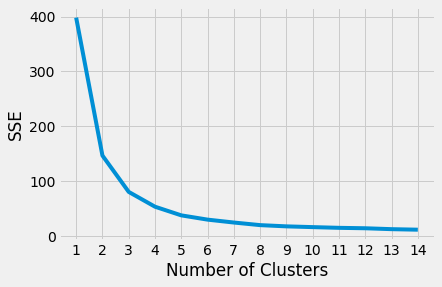

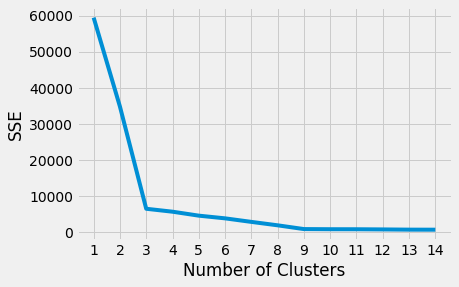

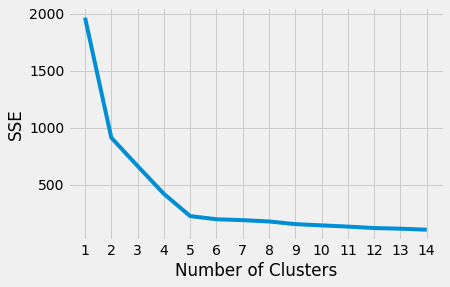

In [173]:
for df_it in df:
    sse = []
    for k in range(1, 15):
        model = FCM(n_clusters=k)
        model.fit(df_it.to_numpy())
        label = model.predict(df_it.to_numpy())
        centroids = pd.DataFrame(model.centers,columns=['x','y'])
        sse.append(SSE_calc(df_it,label,centroids))
    plt.plot(range(1, 15), sse)
    plt.xticks(range(1, 15))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

## DBSCAN 

In [291]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
def plot_eps_for_DBSCAN(df):
    neighbors = NearestNeighbors(n_neighbors=15)
    neighbors_fit = neighbors.fit(df)
    distances, indices = neighbors_fit.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    
def run_DBSCAN(df,eps,min_samples):
    model = DBSCAN(eps=eps,min_samples=min_samples).fit(df)
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    if(n_clusters_>1): return silhouette_score(df, labels)
    return -1

def get_DBSCAN_param(df,i_range):
    max_score = -1
    max_i = None
    max_j = None
    for i in np.arange(*i_range):
        for j in range(1,50):
            score = run_DBSCAN(df,i,j)
            if(score>max_score):
                max_score = score
                max_i = i
                max_j = j
    return max_i,max_j,max_score

def show_DBSCAN(df,eps,min_samples):
    model = DBSCAN(eps=eps,min_samples=min_samples).fit(df)
    labels = model.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('n_clusters:', n_clusters_)
    print('n_noise:',n_noise_)
    plt.scatter(df.x, df.y, s=40, c=labels, cmap=plt.cm.Spectral)
    plt.show()
    if(n_clusters_>1): return silhouette_score(df, labels)
    return -1




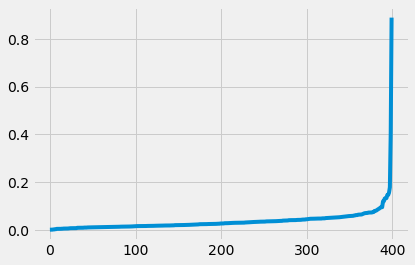

In [230]:
plot_eps_for_DBSCAN(df[0])

0.1950000000000001 3 0.41999030908023327
n_clusters: 3
n_noise: 4


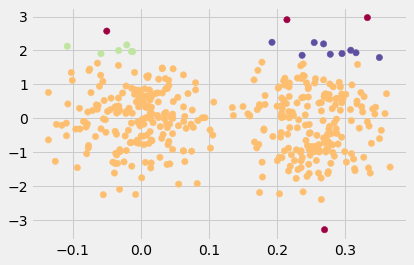

0.41999030908023327

In [299]:
max_i,max_j,max_score = get_DBSCAN_param(df[0],(0.1,0.22,0.005))
print(max_i,max_j,max_score)
show_DBSCAN(df[0],max_i,max_j)

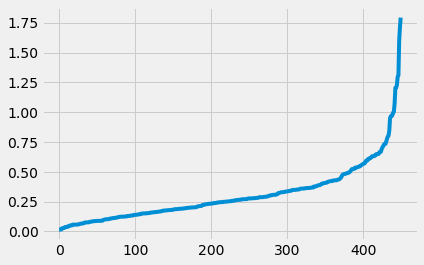

In [293]:
plot_eps_for_DBSCAN(df[1])

0.6950000000000002 3 0.4979435832853752
n_clusters: 11
n_noise: 47


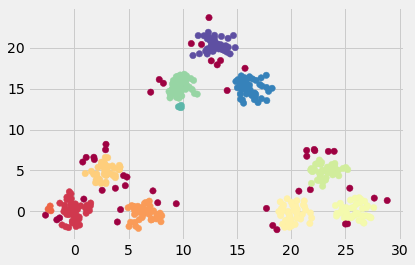

0.4979435832853752

In [298]:
max_i,max_j,max_score = get_DBSCAN_param(df[1],(0.5,0.7,0.005))
print(max_i,max_j,max_score)
show_DBSCAN(df[1],max_i,max_j)

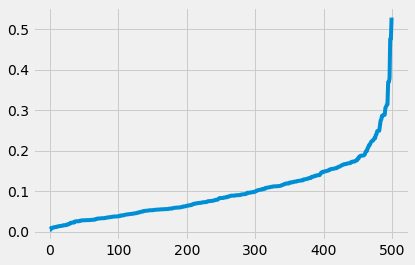

In [295]:
plot_eps_for_DBSCAN(df[2])

0.3650000000000002 6 0.5257991624092554
n_clusters: 5
n_noise: 26


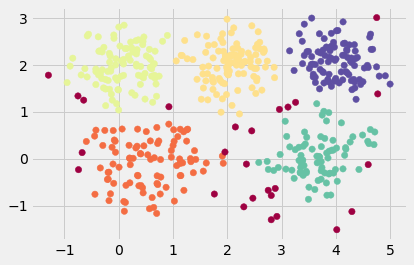

0.5257991624092554

In [301]:
max_i,max_j,max_score = get_DBSCAN_param(df[2],(0.1,0.4,0.005))
print(max_i,max_j,max_score)
show_DBSCAN(df[2],max_i,max_j)